In [271]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

import numpy as np
import scipy
from scipy import signal
from scipy import stats as stats
from scipy.stats import binned_statistic
import mne
import pickle
import pandas as pd

from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm

In [264]:
"""
This cell contains useful functions and variable to analyse the data and plotting settings
"""



################################################
# Plot settings
plo = {}
plo['speed_color']   = '#1f77b4'
plo['density_color'] = '#ff7f03'
plo['cuesec_color']  = 'grey'


# Significance bar and text
def label_diff(i,j,text,X,Y):
    x = (X[i]+X[j])/2
    y = 1.005*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2, 'color':'k'}
    ax.annotate(text, xy=(X[i]+0.2,y+0.03), zorder=1)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

    


################################################

def smooth_psd(p, sz=40, sigma=10):
    '''
    sz :  length of gaussFilter vector
    sigma = 10
    '''
    x = np.linspace(-sz / 2, sz / 2, sz);
    gaussFilter = np.exp(-x** 2 / (2 * sigma**2));
    gaussFilter = gaussFilter / sum (gaussFilter); # normalize
    pp = np.convolve(p, gaussFilter, 'same');
    return pp


    
def hilbert_transform(tmp_lfp_notch, fs, l_f_amp,h_f_amp):

    info = mne.create_info(ch_names=['lfp'], sfreq=fs, ch_types=['eeg'])
    raw = mne.io.RawArray([tmp_lfp_notch], info)

    raw_band = raw.copy()
    raw_band.filter(2, 8, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin')
    raw_hilb = raw_band.copy()
    hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
    raw_hilb.apply_hilbert(hilb_picks)
    raw_phase = raw_hilb.copy()
    raw_phase.apply_function(np.angle, hilb_picks)
    raw_phase = raw_phase.get_data()[0].real

    raw_band = raw.copy()
    raw_band.filter(l_f_amp,h_f_amp, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin')
    raw_hilb = raw_band.copy()
    hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
    raw_hilb.apply_hilbert(hilb_picks)
    raw_amp = raw_hilb.copy()
    raw_amp.apply_function(np.abs, hilb_picks)
    raw_amp = raw_amp.get_data()[0].real

    return raw_phase, raw_amp




def hilbert_transform_get_component(tmp_lfp_notch, fs, low_amp_freq,high_amp_freq, component):
    
    '''
    Transform signal and get either phase or amplitude component
    component: 'phase' or 'amplitude'
    '''

    info = mne.create_info(ch_names=['lfp'], sfreq=fs, ch_types=['eeg'])
    raw = mne.io.RawArray([tmp_lfp_notch], info)
    
    if component == 'phase':

        raw_band = raw.copy()
        raw_band.filter(low_amp_freq,high_amp_freq, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin')
        raw_hilb = raw_band.copy()
        hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
        raw_hilb.apply_hilbert(hilb_picks)
        raw_out = raw_hilb.copy()
        raw_out.apply_function(np.angle, hilb_picks)
        raw_out = raw_out.get_data()[0].real
        
    if component == 'amplitude':


        raw_band = raw.copy()
        raw_band.filter(low_amp_freq,high_amp_freq, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin')
        raw_hilb = raw_band.copy()
        hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
        raw_hilb.apply_hilbert(hilb_picks)
        raw_out = raw_hilb.copy()
        raw_out.apply_function(np.abs, hilb_picks)
        raw_out = raw_out.get_data()[0].real

    return raw_out





def calculate_KB(bs):

    'PAD is the phase amp distribution'
    pad = bs[0]
    pad_2 = np.hstack((pad , pad))

    num_bins = pad_2.size
    n_pevents = float(np.sum(pad_2))
    ppp = -1 * np.sum((pad_2/n_pevents) * np.log((pad_2/n_pevents)))
    K_L = (np.log(num_bins) - ppp) / np.log(num_bins)

    return K_L


In [219]:
## Trial type related info
density = np.tile( np.repeat( np.arange(3), 3 ),3)
speed   = np.tile( np.arange(3), 9 )
dur     = np.tile( np.array([ 18.1, 13.5, 11]), 3).reshape(3,3).T
dd      = np.tile(np.array([50,100,150]),3).reshape(3,3)
K_i     = dd/dur
unii    = K_i[speed,density]
K_i_idx = (  np.tile(np.arange(3),3), np.repeat(np.arange(3),3)  ) 

ttl_info_dict = pickle.load( open( "ttl_info_dict.p", "rb" ) )

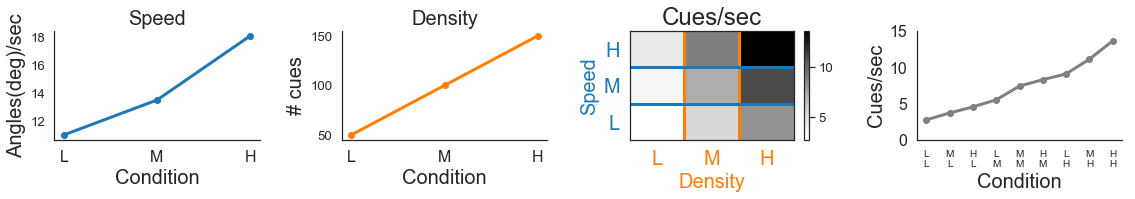

In [250]:
lmh_labels = ['L','M','H']


fig , ax = plt.subplots(1,4)
fig.set_figheight(3)
fig.set_figwidth(16)

fig.set_facecolor('white')

plt.sca(ax[0])    
plt.plot(dur[:,0][::-1],'-o', color=plo['speed_color'],linewidth=3)
plt.ylabel('Angles(deg)/sec', fontsize=20)
plt.title('Speed', fontsize=20)

plt.sca(ax[1])
plt.plot(dd[0],'-o', color=plo['density_color'],linewidth=3)
plt.title('Density', fontsize=20)
plt.ylabel('# cues', fontsize=20)



for ii in range(2):
    ax[ii].spines['right'].set_visible(False)
    ax[ii].spines['top'].set_visible(False)
    plt.sca(ax[ii])
    plt.xticks(range(3),lmh_labels, fontsize=16)
    plt.xlabel('Condition', fontsize=20)

    
    
###### pcolor
plt.sca(ax[2])
plt.pcolor(K_i, cmap='Greys')
plt.colorbar()
plt.title('Cues/sec', fontsize=24)

plt.yticks(np.arange(3)+.5,lmh_labels, fontsize=20,color=plo['speed_color']  )
plt.xticks(np.arange(3)+.5,lmh_labels, fontsize=20,color=plo['density_color']  )

plt.ylabel('Speed', fontsize=20,  color=plo['speed_color'] )
plt.xlabel('Density', fontsize=20,  color=plo['density_color'])

plt.vlines([1,2],0,3,color=plo['density_color'], linewidth=3)
plt.hlines([1,2],0,3,color=plo['speed_color'], linewidth=3)

###### cues/sec line plot
plt.sca(ax[3])
plt.plot(np.sort(np.unique(unii)), '-o', color=plo['cuesec_color'], linewidth=3)
plt.xlabel('Condition', fontsize=20)
plt.ylabel('Cues/sec', fontsize=20)
plt.yticks(fontsize=16)



cue_sec_xticks = []
for ii in range(len(K_i_idx[0])):
    cue_sec_xticks.append( str( ['L','M','H'][K_i_idx[0][ii]]  )+'\n'+str(  ['L','M','H'][K_i_idx[1][ii]]   )   )

plt.xticks( np.arange(K_i_idx[0].size), cue_sec_xticks, fontsize=10)

plt.ylim(0,15)

ax[3].spines['right'].set_visible(False)
ax[3].spines['top'].set_visible(False)

plt.tight_layout()
# plt.savefig('../Figures/experimental_conditions_illustration.pdf')

In [233]:
cue_sec_xticks

['L\nL', 'M\nL', 'H\nL', 'L\nM', 'M\nM', 'H\nM', 'L\nH', 'M\nH', 'H\nH']

In [252]:
subs_psd = []
for ii in ttl_info_dict:

    filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'
    
    
    raw = mne.io.read_raw_fif(filename, preload=True)
    trials = ttl_info_dict[ii]['markers']
    
    
    if trials.size == 27:

        print('Sub: ' , ttl_info_dict[ii]['subject'] )
        for cc in range(len(ttl_info_dict[ii]['hpc_channels_idx'])):


            ch_indx = ttl_info_dict[ii]['hpc_channels_idx'][cc]
            ch_name = ttl_info_dict[ii]['hpc_channels_name'][cc]


            print('Channel: ', ch_indx, ch_name )

            raw_copy = raw.copy().pick_channels([ch_name])
            raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=.1)


            win = 5. * raw.info['sfreq']
            for tt in range(trials.size):

                start = trials[tt]
                stop  = int(start + (raw.info['sfreq']*5))

                freqs, psd = signal.welch(raw_copy.get_data(start=start,stop=stop)[0], raw.info['sfreq'], nperseg=win)

                fmin=2
                fmax=10
                fmin_idx = np.argmin(np.abs(freqs-fmin))
                fmax_idx = np.argmin(np.abs(freqs-fmax))
                

                psd   = psd[fmin_idx:fmax_idx]
                freqs = freqs[fmin_idx:fmax_idx]
                            
                smooth_psd_sz         = 3
                smooth_psd_sigma      = 2
                psd = smooth_psd(psd, sz=smooth_psd_sz, sigma=smooth_psd_sigma)
                peakkss = scipy.signal.find_peaks(psd)[0]
                peakkss = np.mean(freqs[peakkss])

                csw = np.argmin(np.abs(unii[tt]-np.linspace(2,14,5)))
                
                subs_psd.append( [ ttl_info_dict[ii]['subject'], ttl_info_dict[ii]['session'], ch_name, speed[tt], density[tt], unii[tt], csw, peakkss ]  )

                
                
columns=['sub','session','channel','speed','density','cuesec','csw','peakkss'] 
subs_psd = pd.DataFrame(subs_psd,columns=columns )



Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_0_raw.fif...
Isotrak not found
    Range : 142000 ... 350000 =    284.000 ...   700.000 secs
Ready.
Reading 0 ... 208000  =      0.000 ...   416.000 secs...
Sub:  0
Channel:  47 B1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  48 B2
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  55 C1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  56 C2
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_1_raw.fif...
Isotrak not found
    Range : 350000 ... 560000 =    700.000 ...  1120.000 secs
Ready.
Reading 0 ... 210000  =      0.000 ...   420.000 secs...
Sub:  0
Channel:  47 B1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  48 B2
Setting up band-stop fi

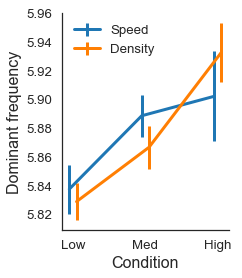

In [260]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)


mmm = subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().T.mean()
sss = subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().T.sem()
plt.errorbar(  np.arange(3)-0.05, mmm, yerr=sss, label='Speed', linewidth=3, color=plo['speed_color'] )

mmm = subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().T.mean()
sss = subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().T.sem()
plt.errorbar(  np.arange(3)+0.05, mmm, yerr=sss, label='Density', linewidth=3, color=plo['density_color'] )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Condition', fontsize=16)
plt.ylabel('Dominant frequency', fontsize=16)
plt.xticks(range(3), ['Low','Med','High']);

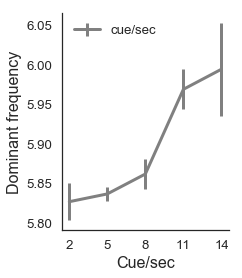

In [259]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)

mmm = subs_psd.groupby(['csw','sub']).mean()['peakkss'].unstack().T.mean()
sss = subs_psd.groupby(['csw','sub']).mean()['peakkss'].unstack().T.sem()
plt.errorbar(  np.arange(mmm.size), mmm, yerr=sss, label='cue/sec', linewidth=3, color=plo['cuesec_color'] )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Cue/sec', fontsize=16)
plt.ylabel('Dominant frequency', fontsize=16)
# plt.xticks(range(3), ['Low','Med','High']);
plt.xticks(np.arange(mmm.index.size), np.linspace(2,14,mmm.index.size).astype(int) );

In [261]:
print('\n\n\n')
print('---------------------------------------------')
print('Speed')
mmm = subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
cw_lm=ols('speed ~ peakkss', data=subs_psd).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

print('\n\n\n')
print('---------------------------------------------')
print('Density')
mmm = subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
print('\n')
cw_lm=ols('density ~ peakkss', data=subs_psd).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))



print('\n\n\n')
print('---------------------------------------------')
print('csw')
mmm = subs_psd.groupby(['csw','sub']).mean()['peakkss'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
cw_lm=ols('csw ~ peakkss', data=subs_psd).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

print('\n\n\n')





---------------------------------------------
Speed
FriedmanchisquareResult(statistic=3.5, pvalue=0.1737739434504451)
             sum_sq     df         F    PR(>F)
peakkss     0.93191    1.0  1.396664  0.237684
Residual  467.06809  700.0       NaN       NaN




---------------------------------------------
Density
FriedmanchisquareResult(statistic=6.5, pvalue=0.03877420783172202)


              sum_sq     df         F    PR(>F)
peakkss     3.641878    1.0  5.489976  0.019405
Residual  464.358122  700.0       NaN       NaN




---------------------------------------------
csw
FriedmanchisquareResult(statistic=12.200000000000003, pvalue=0.01592436080834918)
              sum_sq     df         F    PR(>F)
peakkss    10.508230    1.0  8.257245  0.004182
Residual  890.825104  700.0       NaN       NaN






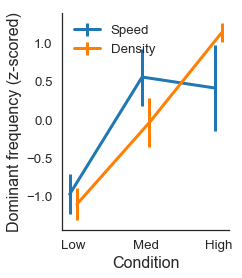

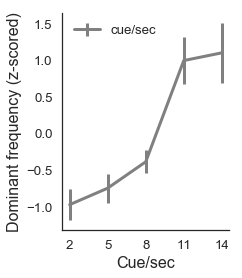

In [263]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)

mmm = subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().apply(stats.zscore).T.mean()
sss = subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().apply(stats.zscore).T.sem()
plt.errorbar(  np.arange(3)-0.05, mmm, yerr=sss, label='Speed', linewidth=3,color=plo['speed_color'] )

mmm = subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().apply(stats.zscore).T.mean()
sss = subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().apply(stats.zscore).T.sem()
plt.errorbar(  np.arange(3)+0.05, mmm, yerr=sss, label='Density', linewidth=3, color=plo['density_color'] )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Condition', fontsize=16)
plt.ylabel('Dominant frequency (z-scored)', fontsize=16)
plt.xticks(range(3), ['Low','Med','High']);






fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)

mmm = subs_psd.groupby(['csw','sub']).mean()['peakkss'].unstack().apply(stats.zscore).T.mean()
sss = subs_psd.groupby(['csw','sub']).mean()['peakkss'].unstack().apply(stats.zscore).T.sem()
plt.errorbar(  np.arange(mmm.size), mmm, yerr=sss, label='cue/sec', linewidth=3,color=plo['cuesec_color'] )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Cue/sec', fontsize=16)
plt.ylabel('Dominant frequency (z-scored)', fontsize=16)
plt.xticks(np.arange(mmm.index.size), np.linspace(2,14,mmm.index.size).astype(int) );

# Dominant freq at rest vs navigation

In [125]:
dominant_freq_rest_vs_navigation = []
for ii in ttl_info_dict:

    filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'
    
    
    raw = mne.io.read_raw_fif(filename, preload=True)
    trials = ttl_info_dict[ii]['markers']
    
    
    if trials.size == 27:

        print('Sub: ' , ttl_info_dict[ii]['subject'] )
        for cc in range(len(ttl_info_dict[ii]['hpc_channels_idx'])):


            ch_indx = ttl_info_dict[ii]['hpc_channels_idx'][cc]
            ch_name = ttl_info_dict[ii]['hpc_channels_name'][cc]


            print('Channel: ', ch_indx, ch_name )

            raw_copy = raw.copy().pick_channels([ch_name])
            raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=.1)


            win = 3. * raw.info['sfreq']
            for tt in range(1,trials.size):

                def get_peaks(psd,freqs):
                    fmin=2
                    fmax=10
                    fmin_idx = np.argmin(np.abs(freqs-fmin))
                    fmax_idx = np.argmin(np.abs(freqs-fmax))

                    psd   = psd[fmin_idx:fmax_idx]
                    freqs = freqs[fmin_idx:fmax_idx]

                    smooth_psd_sz         = 3
                    smooth_psd_sigma      = 2
                    psd = smooth_psd(psd, sz=smooth_psd_sz, sigma=smooth_psd_sigma)
                    peakkss = scipy.signal.find_peaks(psd)[0]
                    peakkss = np.mean(freqs[peakkss])
                    return peakkss

                
                start = trials[tt] + 200#raw.info['sfreq']*1
                stop  = int(start + (raw.info['sfreq']*3))
                freqs, psd = signal.welch(raw_copy.get_data(start=start,stop=stop)[0], raw.info['sfreq'], nperseg=win)
                freq_nav = get_peaks(psd,freqs)

                start = trials[tt]
                stop  = int(start - (raw.info['sfreq']*3))
                freqs, psd = signal.welch(raw_copy.get_data(start=stop,stop=start)[0], raw.info['sfreq'], nperseg=win)
                freq_rest = get_peaks(psd,freqs)

                dominant_freq_rest_vs_navigation.append( [ ttl_info_dict[ii]['subject'], ttl_info_dict[ii]['session'], ch_name, freq_rest,freq_nav  ]  )

                
                
columns=['sub','session','channel','freq_rest','freq_nav']
dominant_freq_rest_vs_navigation = pd.DataFrame(dominant_freq_rest_vs_navigation,columns=columns )


Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_0_raw.fif...
Isotrak not found
    Range : 142000 ... 350000 =    284.000 ...   700.000 secs
Ready.
Reading 0 ... 208000  =      0.000 ...   416.000 secs...
Sub:  0
Channel:  47 B1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  48 B2
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  55 C1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  56 C2
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_1_raw.fif...
Isotrak not found
    Range : 350000 ... 560000 =    700.000 ...  1120.000 secs
Ready.
Reading 0 ... 210000  =      0.000 ...   420.000 secs...
Sub:  0
Channel:  47 B1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  48 B2
Setting up band-stop fi

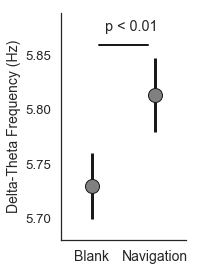

In [195]:
mm_n = dominant_freq_rest_vs_navigation.groupby(['sub']).mean()['freq_nav'].mean()
ss_n = dominant_freq_rest_vs_navigation.groupby(['sub']).mean()['freq_nav'].sem()

mm_r = dominant_freq_rest_vs_navigation.groupby(['sub']).mean()['freq_rest'].mean()
ss_r = dominant_freq_rest_vs_navigation.groupby(['sub']).mean()['freq_rest'].sem()



fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)

plt.errorbar(  [0,1], [mm_r,mm_n], yerr=[ss_r,ss_n], color='k', linestyle='', linewidth=3, marker='o', 
               markersize=14, markerfacecolor='grey')

# Add significance text and bar
ind = [0,1]
menMeans = [mm_r,mm_n]
if stats.ttest_ind( dominant_freq_rest_vs_navigation['freq_nav'],
                   dominant_freq_rest_vs_navigation['freq_rest'])[1] < 0.01:
    pval_str = 'p < 0.01'
label_diff(0,1,pval_str,ind,menMeans)


fig.patch.set_facecolor('xkcd:white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim(-.5,1.5)
plt.ylim(5.68,  np.max([mm_r,mm_n])*1.013 )
plt.sca(ax)
plt.ylabel('Delta-Theta Frequency (Hz)', fontsize=14)
plt.xticks(  [0,1], ['Blank', 'Navigation'], fontsize=14)
plt.tight_layout()

# Welch's periodogram

Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_0_raw.fif...
Isotrak not found
    Range : 142000 ... 350000 =    284.000 ...   700.000 secs
Ready.
Reading 0 ... 208000  =      0.000 ...   416.000 secs...
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected


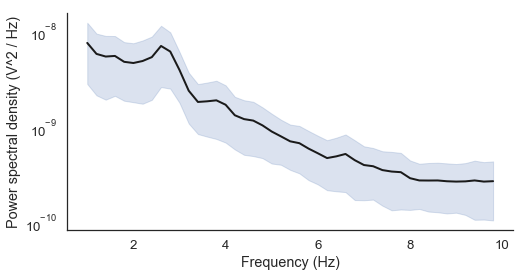

In [200]:
ii = 0

filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'


raw = mne.io.read_raw_fif(filename, preload=True)
trials = ttl_info_dict[ii]['markers']


tmp_psd =[]

for cc in range(len(ttl_info_dict[ii]['hpc_channels_idx'])):


    ch_indx = ttl_info_dict[ii]['hpc_channels_idx'][cc]
    ch_name = ttl_info_dict[ii]['hpc_channels_name'][cc]

    raw_copy = raw.copy().pick_channels([ch_name])
    raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=.1)

    win = 5. * raw.info['sfreq']

    freqs, psd = signal.welch(raw_copy.get_data()[0], raw.info['sfreq'], nperseg=win)
    tmp_psd.append(psd)


tmp_psd = np.array(tmp_psd)


mean_psd = np.mean(tmp_psd,axis=0)
sem_psd = stats.sem(tmp_psd,axis=0)

fmin=1
fmax=10
fmin_idx = np.argmin(np.abs(freqs-fmin))
fmax_idx = np.argmin(np.abs(freqs-fmax))



plt.figure(figsize=(8, 4))

sns.set(font_scale=1.2, style='white')
plt.semilogy(freqs[fmin_idx:fmax_idx], mean_psd[fmin_idx:fmax_idx], color='k', lw=2)
plt.fill_between(freqs[fmin_idx:fmax_idx], mean_psd[fmin_idx:fmax_idx]-sem_psd[fmin_idx:fmax_idx],
                                           mean_psd[fmin_idx:fmax_idx]+sem_psd[fmin_idx:fmax_idx],alpha=0.2, color='b')



plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
sns.despine()


# PAC

In [366]:

def get_phase_amplitude(l_f_amp,h_f_amp):

    amp_phase = {}

    for ii in ttl_info_dict:

        filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'

        amp_phase[ii] = {}
        amp_phase[ii]['info'] = [ttl_info_dict[ii]['subject'],ttl_info_dict[ii]['session']]
        amp_phase[ii]['phase'] = []
        amp_phase[ii]['amp'] = []

        raw = mne.io.read_raw_fif(filename, preload=True, verbose=False)
        trials = ttl_info_dict[ii]['markers']

        if trials.size == 27:

            print('Sub: ' , ttl_info_dict[ii]['subject'] )
            for cc in range(len(ttl_info_dict[ii]['hpc_channels_idx'])):


                ch_indx = ttl_info_dict[ii]['hpc_channels_idx'][cc]
                ch_name = ttl_info_dict[ii]['hpc_channels_name'][cc]


                print('Channel: ', ch_indx, ch_name )

                raw_copy = raw.copy().pick_channels([ch_name])
                raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=.1, verbose=False)

                tmp_lfp = raw_copy.get_data()[0]

                raw_phase, raw_amp = hilbert_transform(tmp_lfp, raw.info['sfreq'],l_f_amp,h_f_amp)

                amp_phase[ii]['phase'].append( raw_phase)
                amp_phase[ii]['amp'].append( raw_amp)
                
                
    return amp_phase


def organize_amp_phase_to_pandas(amp_phase):
    trial_begin           = 0
    trial_end             = 1500#4000
    # trial_begin           = 0
    # trial_end             = 1500


    ## Trial type
    tmp_density = np.tile( np.repeat( np.arange(3), 3 ),3)
    tmp_speed = np.tile( np.arange(3), 9 )
    tmp_dur = [ 18.1, 13.5, 11]
    tmp_dd = [50,100,150]


    log_pac = []
    for sub in ttl_info_dict:

        idx_trials = trials = ttl_info_dict[sub]['markers']


        for cc in range(len(amp_phase[sub]['amp'])):

            tmp_amp = amp_phase[sub]['amp'][cc]
            tmp_phase = amp_phase[sub]['phase'][cc]


            for trial in range(len(idx_trials)):

                tmp_tmp_amp = tmp_amp[ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]
                tmp_tmp_phase = tmp_phase[ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]

                bs = binned_statistic(tmp_tmp_phase,tmp_tmp_amp)
                kb = calculate_KB(bs)

                cs = tmp_dd[tmp_density[trial]]/tmp_dur[tmp_speed[trial]]
                csw = np.argmin(np.abs(cs-np.linspace(2,14,5)))
                log_pac.append( [sub, tmp_density[trial], tmp_speed[trial], cs, csw, kb] )


    log_pac = pd.DataFrame(log_pac, columns=['sub','density','speed','cuesec','cuesec_w','kb'] )
    
    return log_pac

In [365]:
def plot_pac_speed_density(log_pac):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    fig.set_figheight(4)
    fig.set_figwidth(3)

    var_of_interst = 'kb'

    mmd = log_pac.groupby(['density','sub']).mean()[var_of_interst].unstack().T.median()  #log_pac.groupby(['density']).mean()[var_of_interst]
    mms = log_pac.groupby(['speed','sub']).mean()[var_of_interst].unstack().T.median()  #log_pac.groupby(['speed']).mean()[var_of_interst]
    ssd = log_pac.groupby(['density','sub']).mean()[var_of_interst].unstack().T.sem() #log_pac.groupby(['density']).sem()[var_of_interst]
    sss = log_pac.groupby(['speed','sub']).mean()[var_of_interst].unstack().T.sem() #log_pac.groupby(['speed']).sem()[var_of_interst]

    plt.errorbar(  np.arange(3)-0.05, mms, yerr=sss, label='Speed', linewidth=3 )
    plt.errorbar(  np.arange(3)+0.05, mmd, yerr=ssd, label='Density', linewidth=3  )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.sca(ax)
    plt.legend( frameon=False, loc='lower left')
    plt.ylabel('PAC (' + str(l_f_amp) +'-'+str(h_f_amp)+'Hz)'  , fontsize=16)
    plt.xlabel('Condition', fontsize=16)
    plt.xticks(range(3), ['Low','Med','High'])
    plt.tight_layout()

    # plt.ylim(0.0015,0.005)  ##55-95
    # plt.ylim(0.002,0.009)   ##15-30
    plt.ylim(0.002,0.007)     ##30-47

    ym = plt.ylim()[1]*0.95

    log_pac_np_tmp = log_pac.groupby(['density','sub']).mean()[var_of_interst].unstack().T.to_numpy()
    pval_str = np.round(stats.friedmanchisquare(*[ log_pac_np_tmp[:,ii]   for ii in range(log_pac_np_tmp.shape[1]) ])[1],3)
    pval_str = 'p='+str(pval_str)
    plt.text( 0.4, ym, pval_str,  fontdict=dict(color=plo['density_color']) )

    log_pac_np_tmp = log_pac.groupby(['speed','sub']).mean()[var_of_interst].unstack().T.to_numpy()
    pval_str = np.round(stats.friedmanchisquare(*[ log_pac_np_tmp[:,ii]   for ii in range(log_pac_np_tmp.shape[1]) ])[1],3)
    pval_str = 'p='+str(pval_str)
    plt.text( 0.4, ym-.0005, pval_str,  fontdict=dict(color=plo['speed_color']) )

    plt.tight_layout()
    # plt.savefig('../Figures/pac_condition.pdf')
    
    
    
def plot_pac_cuesec(log_pac):
    mmcs = log_pac.groupby(['cuesec_w','sub']).mean()[var_of_interst].unstack().T.median()  #log_pac.groupby(['density']).mean()[var_of_interst]
    sscs = log_pac.groupby(['cuesec_w','sub']).mean()[var_of_interst].unstack().T.sem() #log_pac.groupby(['density']).sem()[var_of_interst]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.set_figheight(4)
    fig.set_figwidth(3)

    ym = mmcs.max()*1.1 #sum(plt.ylim())/2
    log_pac_np_tmp = log_pac.groupby(['cuesec_w','sub']).mean()[var_of_interst].unstack().T.to_numpy()
    pval_str = np.round(stats.friedmanchisquare(*[ log_pac_np_tmp[:,ii]   for ii in range(log_pac_np_tmp.shape[1]) ])[1],3)
    pval_str = 'p='+str(pval_str)
    plt.text( 0.4, ym, pval_str,  fontdict=dict(color=plo['cuesec_color']) )

    # plt.ylim(0.0015,0.005)  ##55-95
    # plt.ylim(0.002,0.009)   ##15-30
    plt.ylim(0.002,0.007)     ##30-47

    ax.errorbar(  range(mmcs.size), mmcs, yerr=sscs, linewidth=3, label=pval_str, color=plo['cuesec_color'] )

    fig.patch.set_facecolor('xkcd:white')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.sca(ax)
    plt.ylabel('PAC (' + str(l_f_amp) +'-'+str(h_f_amp)+'Hz)'  , fontsize=16)
    plt.xlabel('Cues/sec level', fontsize=16)

    plt.xticks(np.arange(mmm.index.size), np.linspace(2,14,mmm.index.size).astype(int) );
    plt.tight_layout()
    # plt.savefig('../Figures/pac_cuesec.pdf')


Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_0_raw.fif...
Isotrak not found
    Range : 142000 ... 350000 =    284.000 ...   700.000 secs
Ready.
Reading 0 ... 208000  =      0.000 ...   416.000 secs...
Sub:  0
Channel:  47 B1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 825 samples (1.650 sec) selected
Setting up band-pass filter from 30 - 47 Hz
Filter length of 825 samples (1.650 sec) selected
Channel:  48 B2
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 825 samples (1.650 sec) selected
Setting up band-pass filter f

Channel:  20 B'2
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 ... 205000 =      0.000 ...   410.000 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 825 samples (1.650 sec) selected
Setting up band-pass filter from 30 - 47 Hz
Filter length of 825 samples (1.650 sec) selected
Channel:  29 C'1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 ... 205000 =      0.000 ...   410.000 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 825 samples (1.650 sec) selected
Setting up band-pass filter from 30 - 47 Hz
Filter length of 825 samples (1.650 sec) selected
Channel:  30 C'2
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205001
    Range : 0 

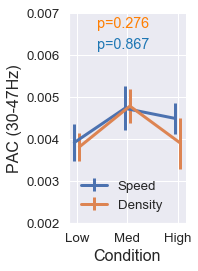

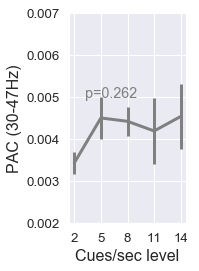

In [367]:
l_f_amp,h_f_amp= 30,47
amp_phase = get_phase_amplitude(l_f_amp,h_f_amp)
log_pac = organize_amp_phase_to_pandas(amp_phase)
plot_pac_speed_density(log_pac)
plot_pac_cuesec(log_pac)